In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns

import warnings

warnings.filterwarnings(action="ignore")

In [2]:
def mean(s):
    return np.sum(s) / len(s)

In [3]:
def mean1(s) : 
    return np.sum(s[ : -1]) / (len(s)-1)

In [4]:
def shift_num(df, int1) : 
    df[f'user_correct_{-1 * int1}'] = df.groupby('userID')['answerCode'].shift(int1).fillna(0).apply(lambda x : 0 if x == -1 else x)
    return df

In [5]:
def beforecorrect_tag(df, str1) : 
    df[f'user_{str1}_beforecount'] = df.groupby(["userID", str1])["answerCode"].cumcount() # 문제를 풀기 전 맞은 문항의 누적 개수
    df[f"user_{str1}_beforecorrect"] = (df.groupby(["userID", str1])["answerCode"].transform(lambda x: x.cumsum().shift(1)).fillna(0)) # 문제를 풀기 전 맞은 문항의 누적 합
    df[f"user_{str1}_beforeanswerrate"] = (df[f"user_{str1}_beforecorrect"] / df[f'user_{str1}_beforecount']).fillna(0.0) # 문제를 풀기 전 누적 정답률

    return df

In [6]:
def groupby_answer(df, str1) :  
    df_groupby_answer = df[df['answerCode'] != -1].groupby([str1]).agg({
        str1 : 'count',
        'answerCode' : mean
    })

    df_groupby_answer.columns = [f'{str1}_count', f'{str1}_answer']
    df = pd.merge(df, df_groupby_answer, on=[str1], how='left')

    return df

In [7]:
def user_groupby_answer(df, str1) : 
    df_groupby_answer = df[df['answerCode'] != -1].groupby(['userID', str1]).agg({
        str1 : 'count',
        'answerCode' : mean
    })

    df_groupby_answer.columns = [f'user_{str1}_count', f'user_{str1}_answer']
    df = pd.merge(df, df_groupby_answer, on=['userID', str1], how='left')
    return df

In [8]:
train = pd.read_csv('/data/ephemeral/data/train_data.csv')
test = pd.read_csv('/data/ephemeral/data/test_data.csv')

df = pd.concat([train, test])
df = df.reset_index(drop = True)

df["Timestamp"] = pd.to_datetime(df["Timestamp"])

df = df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)

In [9]:
# 정답률에 유의미한 차이가 있는 month, weekday, hour에 대해 feature 추가 
df['month'] = df['Timestamp'].dt.month # 1~12 OX (11, 12에서 차이가 큼)
df['day'] = df['Timestamp'].dt.day # X 
df['weekday'] = df['Timestamp'].dt.weekday # 0~6 OX (토 ,일은 count가 특히 적음)
df['hour'] = df['Timestamp'].dt.hour # 0~23 O
df['min'] = df['Timestamp'].dt.minute # X

# assessmentItemID와 testId에 대한 대분류 feature 추가
df['first3'] = df['assessmentItemID'].apply(lambda x : x[2]).astype(int) # 010 ~ 090 O
df['mid3'] = df['assessmentItemID'].apply(lambda x : x[4:7]).astype(int) # 001~198 OX
df['last3'] = df['assessmentItemID'].apply(lambda x : x[-3:]).astype(int) # 문항 번호 X

Time 및 Sequence

In [10]:
df["user_beforecorrect"] = (df.groupby("userID")["answerCode"].transform(lambda x: x.cumsum().shift(1)).fillna(0.0)) # 문제를 풀기 전 맞은 문항의 누적 합
df["user_beforecount"] = df.groupby("userID")["answerCode"].cumcount() # 문제를 풀기 전 문제를 푼 누적합
df["user_beforeanswerrate"] = (df['user_beforecorrect'] / df['user_beforecount']).fillna(0.0) # 문제를 풀기 전 누적 정답률

In [11]:
# 시험지 내 문제를 푸는데 걸린 시간

diff = df.loc[:, ['userID', 'Timestamp']].groupby('userID').diff().fillna(pd.Timedelta(seconds=0))
diff = diff.fillna(pd.Timedelta(seconds=0))
diff = diff['Timestamp'].apply(lambda x: x.total_seconds())

df['elapsed'] = diff.shift(-1)

user_test_groupby_answer = df.groupby(['userID', 'testId']).agg({
    'elapsed' : mean1
})

user_test_groupby_answer.columns = ['test_elapsed_mean']
df = pd.merge(df, user_test_groupby_answer, on=['userID', 'testId'], how='left')
    
df.loc[df.groupby(['userID', 'testId']).tail(1).index, 'elapsed'] = df['test_elapsed_mean']
df = df.drop(['test_elapsed_mean'], axis = 1)

In [12]:
for i in range(-2, 3) : 
    if i == 0 : 
        pass
    else : 
        df = shift_num(df, i)

In [13]:
df = beforecorrect_tag(df, 'first3')
df = beforecorrect_tag(df, 'KnowledgeTag')

In [14]:
df['rolling3_time'] = df.groupby(['userID'])['elapsed'].rolling(3).mean().fillna(0).values
df.loc[df.groupby(['userID']).head(1).index, 'rolling3_time'] = df.loc[df.groupby(['userID']).head(1).index, 'elapsed']

for group, group_df in df.groupby('userID'):
    first_two_elapsed_mean = group_df['elapsed'].head(2).mean()
    df.loc[group_df.index[1], 'rolling3_time'] = first_two_elapsed_mean

User-AssessmentItemID 정답률 => first3, mid3, TestID 기준

In [15]:
user_first3_groupby = df.groupby(['userID', "first3"]).agg(
    {
        "first3": "count",
        "answerCode": mean,
    }
)

user_first3_groupby


first3  answerCode
userID first3                    
0      2           36    0.722222
       6          346    0.791908
       8          363    0.468320
1      4          581    0.822719
       9          352    0.903409
...               ...         ...
7439   4           16    0.625000
7440   3           10    0.400000
       5            5    0.400000
7441   3            5    0.200000
       4            4    1.000000

[19739 rows x 2 columns]

array([[<Axes: title={'center': 'first3'}>,
        <Axes: title={'center': 'answerCode'}>]], dtype=object)

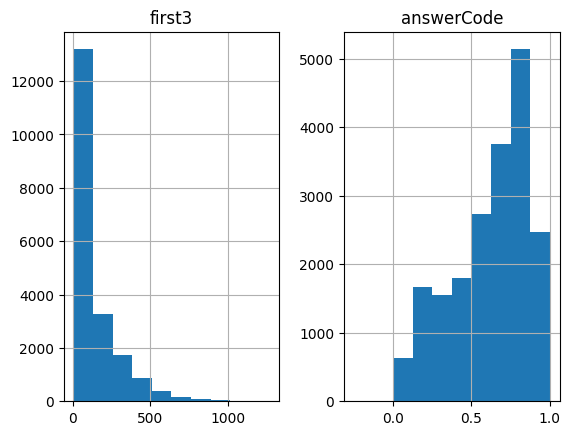

In [16]:
user_first3_groupby.hist()

In [17]:
user_mid3_groupby = df.groupby(['userID', "mid3"]).agg(
    {
        "mid3": "count",
        "answerCode": mean,
    }
)

user_mid3_groupby


mid3  answerCode
userID mid3                  
0      1        6    1.000000
       2        6    0.833333
       3        7    0.857143
       4        8    0.500000
       5        7    0.857143
...           ...         ...
7440   96       5    0.400000
       136      5    0.600000
       197      5    0.200000
7441   71       5    0.200000
       165      4    1.000000

[351069 rows x 2 columns]

array([[<Axes: title={'center': 'mid3'}>,
        <Axes: title={'center': 'answerCode'}>]], dtype=object)

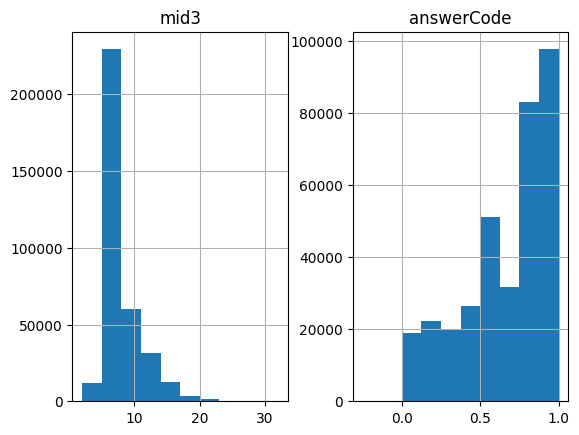

In [18]:
user_mid3_groupby.hist()

In [19]:
user_test_groupby = df.groupby(['userID', "testId"]).agg(
    {
        "testId": "count",
        "answerCode": mean,
    }
)

user_test_groupby


testId  answerCode
userID testId                        
0      A020000172       6    0.666667
       A020000174       5    0.800000
       A020000181       6    0.500000
       A020000182       5    1.000000
       A020000183       7    1.000000
...                   ...         ...
7440   A030000136       5    0.600000
       A030000197       5    0.200000
       A050000096       5    0.400000
7441   A030000071       5    0.200000
       A040000165       4    1.000000

[407189 rows x 2 columns]

array([[<Axes: title={'center': 'testId'}>,
        <Axes: title={'center': 'answerCode'}>]], dtype=object)

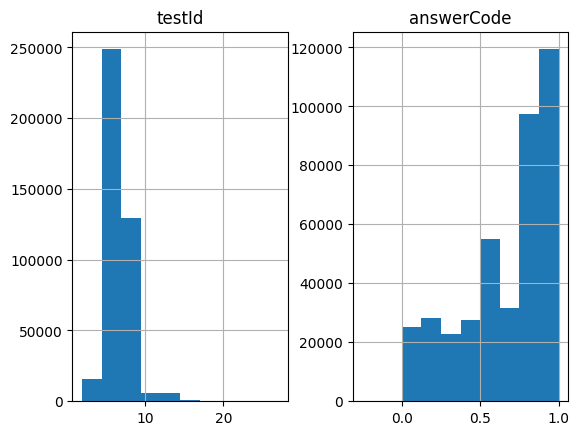

In [20]:
user_test_groupby.hist()